Trying to use [fhirtordf](https://github.com/BD2KOnFHIR/fhirtordf) for parsing the FHIR bundle from [synthea](https://synthetichealth.github.io/synthea/) to RDF, which can then be transformed to knowledge graph for use in RAG or other operations.

In [4]:
%pip install rdflib networkx netgraph fhirtordf --user

Note: you may need to restart the kernel to use updated packages.


In [5]:
from rdflib import Graph, URIRef, BNode, OWL, RDF, Literal, Namespace
from fhirtordf.loaders.fhirjsonloader import fhir_json_to_rdf
from fhirtordf.fhir.fhirmetavoc import FHIRMetaVoc
import networkx as nx
import json

C:\Users\Peter\AppData\Roaming\Python\Python312\site-packages\rdflib\plugin.py:111: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import iter_entry_points


In [6]:
g = fhir_json_to_rdf(
        json_fname='C:/Users/Peter/Documents/GitHub/daily-coding/fhir/Aaron697_Brekke496_2fa15bc7-8866-461a-9000-f739e425860a.json',
        # base_uri='https://peterdobbs77.github.io/fhir/',
        metavoc = FHIRMetaVoc(mv_file_loc="http://build.fhir.org/fhir.ttl")
    )

In [7]:
# print(g.serialize(format='turtle').decode('utf-8'))

In [8]:
print(len(g))

1276


Something is off in the way that the references are being created. I think `fhirtordf` is struggling to establish references based on the structure of the synthea-generated data.

Instead let's try to do the conversion manually...

In [9]:
from fhir_to_rdf import FhirGraph   # local dev work by Peter N. Dobbs
import json

with open('../../fhir/Aaron697_Brekke496_2fa15bc7-8866-461a-9000-f739e425860a.json', 'r') as f:
    fhir_bundle = json.load(f)

fhir_graph = FhirGraph(fhir_bundle)
result_graph = fhir_graph.generate()

# print(result_graph.serialize(format='turtle').decode('utf-8'))

In [10]:
for s in result_graph.subjects():
    if isinstance(s, BNode):
        print("Blank node:", s)
        for subj, pred in result_graph.subject_predicates(object=s):
            print(f"{subj} -- {pred} -> [blank node]")
        for pred, obj in result_graph.predicate_objects(subject=s):
            print(f"[blank node] -- {pred} -> {obj}")

C:\Users\Peter\AppData\Local\Temp\ipykernel_12684\1962708043.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


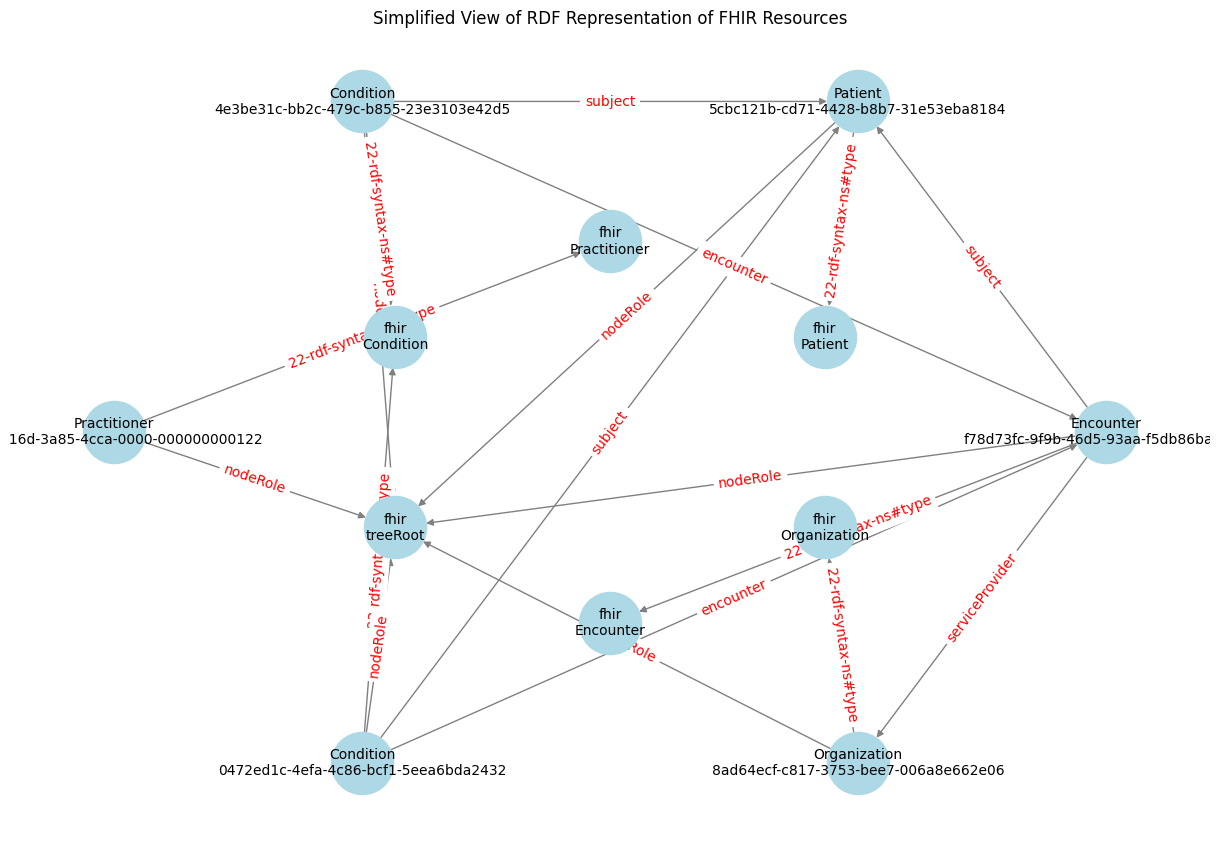

In [11]:
from rdflib import URIRef
import networkx as nx
import matplotlib.pyplot as plt

FHIR = Namespace("http://hl7.org/fhir/")

def pretty_view_rdf_graph(g: Graph, format="turtle", title="Simplified View of RDF Representation of FHIR Resources"):
    '''Visualize simplified view of the RDF graph, 
        just showing connections between FHIR Resources
    :param g: `rdflib.Graph`'''
    # Create NetworkX graph
    nx_graph = nx.DiGraph()

    for subj, pred, obj in g:
        if not isinstance(obj, URIRef):
            continue
        # Convert nodes to readable strings
        subj_str = str(subj).split('/')[-2] + '\n' + str(subj).split('/')[-1]
        pred_str = str(pred).split('/')[-1]
        obj_str = str(obj).split('/')[-2] + '\n' + str(obj).split('/')[-1]

        # Add edge with predicate label
        nx_graph.add_edge(subj_str, obj_str, label=pred_str)
    
    # Draw graph
    # pos = nx.arf_layout(nx_graph, seed=42) # ARF is better than spring
    pos = nx.shell_layout(nx_graph, 
                            nlist=[[x for x in nx_graph.nodes() if 'fhir' in x],
                                    [x for x in nx_graph.nodes() if 'fhir' not in x]])
    edge_labels = nx.get_edge_attributes(nx_graph, 'label')

    plt.figure(figsize=(12, 8))
    nx.draw(nx_graph, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=2000, font_size=10)
    nx.draw_networkx_edge_labels(nx_graph, pos, edge_labels=edge_labels, font_color='red')
    plt.title(title)
    plt.tight_layout()
    plt.show()

pretty_view_rdf_graph(result_graph)

Okay, this is all coming together! 🎉

Notice, though, that the Practitioner is missing linkages to other resources! (TODO: expand on code to support linking Practitioner to appropriate references)

Let's try loading more resources and visualizing from there!

673


C:\Users\Peter\AppData\Local\Temp\ipykernel_12684\1962708043.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


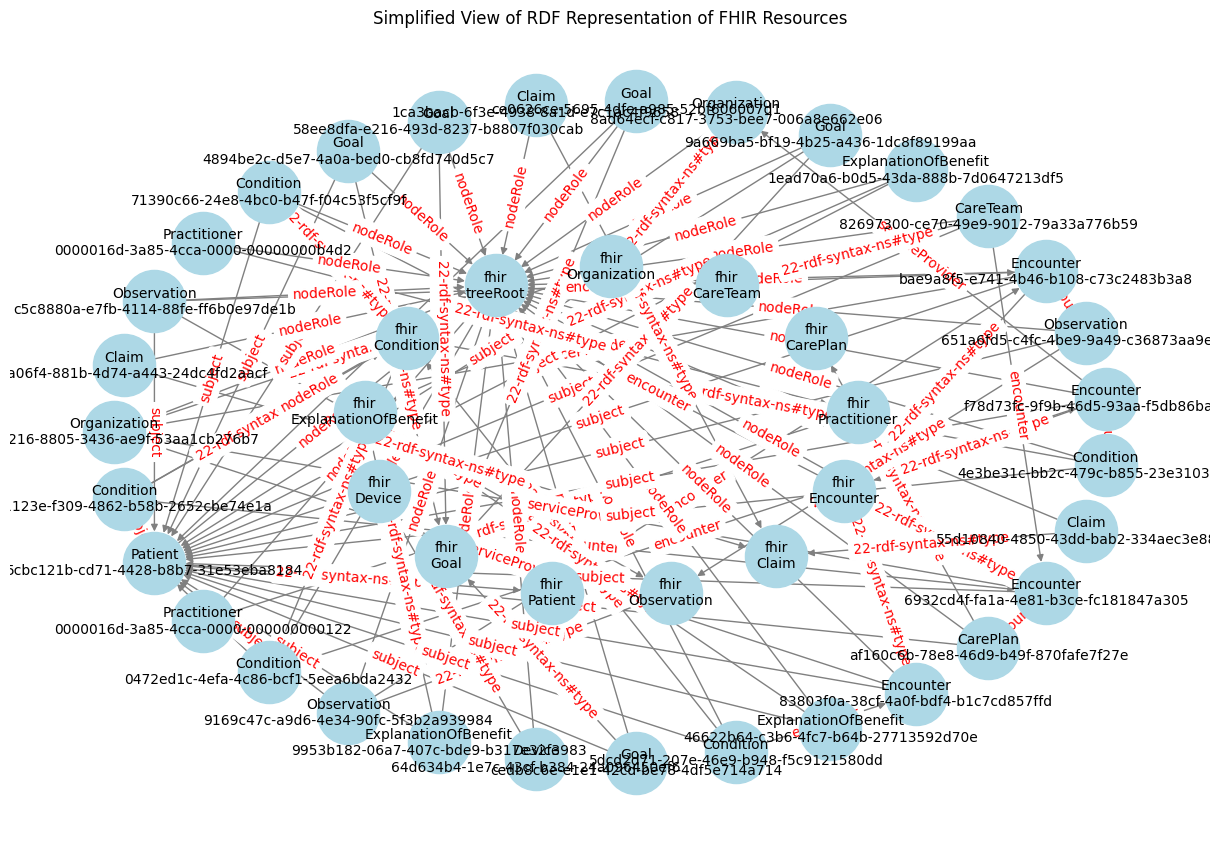

In [12]:
with open('../../fhir/Aaron697_Brekke496_2fa15bc7-8866-461a-9000-f739e425860a.json', 'r') as f:
    fhir_bundle = json.load(f)

bigger_fhir_graph = FhirGraph(fhir_bundle)
bigger_result_graph = bigger_fhir_graph.generate(limit=30)

print(len(bigger_result_graph))

pretty_view_rdf_graph(bigger_result_graph)

## Multiple Bundles

Now let's try loading multiple Bundles of FHIR Resources and processing them

We'll start with a limited scope of each of the Bundles, to make sure we get the basics right before we blow up our memory.

233


C:\Users\Peter\AppData\Local\Temp\ipykernel_12684\1962708043.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


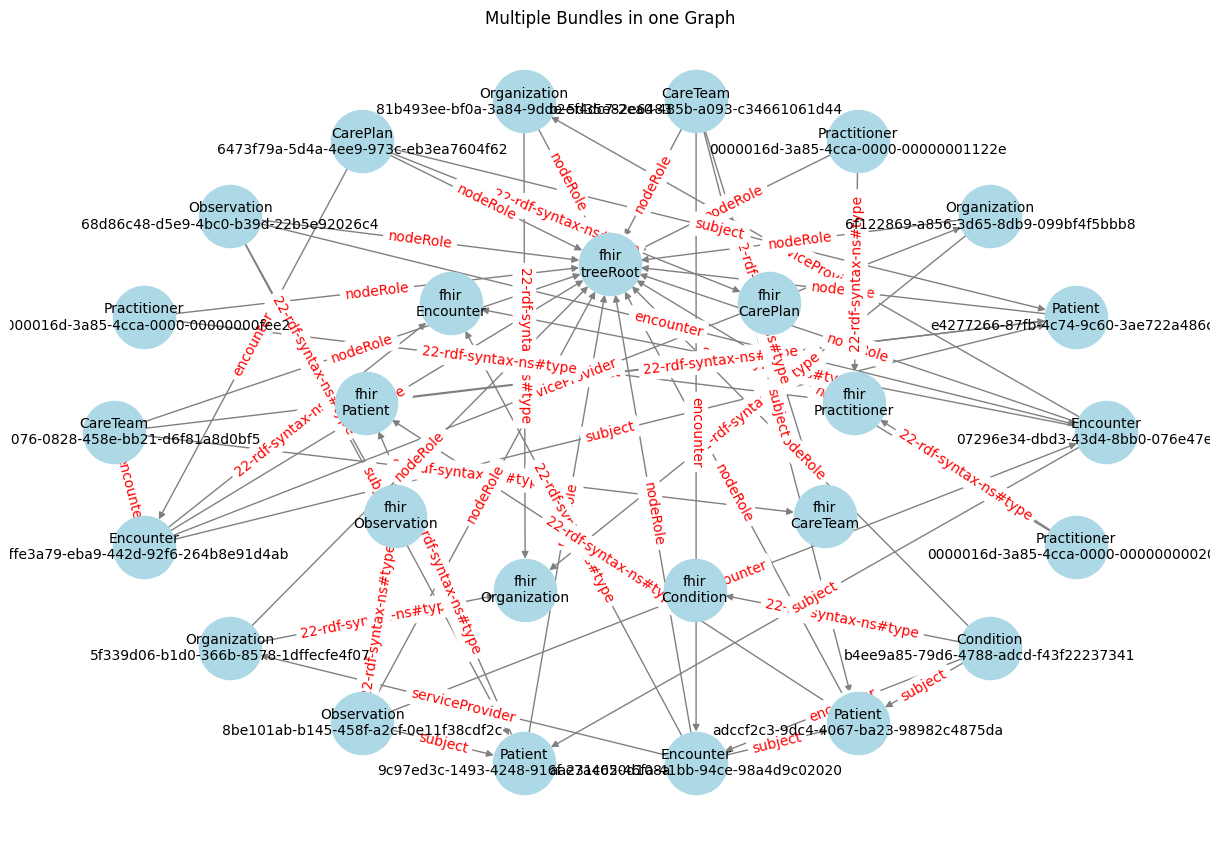

In [13]:
patient_file_paths = [
    '../../fhir/Aaron697_Stiedemann542_41166989-975d-4d17-b9de-17f94cb3eec1.json',
    '../../fhir/Danyell947_Kautzer186_132ff57e-a51d-425e-af89-16d95db75d0f.json',
    '../../fhir/Rocio28_Zboncak558_736aec9a-fba2-4b15-ab38-09af9998c035.json'
]

large_multi_graph = Graph()

for fpath in patient_file_paths:
    with open(fpath, 'r') as f:
        fhir_bundle = json.load(f)
    large_multi_fhirgraph = FhirGraph(fhir_bundle, large_multi_graph)
    large_multi_graph = large_multi_fhirgraph.generate()

print(len(large_multi_graph))

pretty_view_rdf_graph(large_multi_graph, title="Multiple Bundles in one Graph")

Notice that multiple instances of the Patient resource are present now 🕺

# Start from the source

FHIR publishes a Turtle file for defining the structure of FHIR resources. Let's try that!

Build version: [http://build.fhir.org/fhir.ttl](http://build.fhir.org/fhir.ttl)

In [14]:
# 
from rdflib import Graph

fhir_kg = Graph()
fhir_kg.parse('http://build.fhir.org/fhir.ttl')
print(len(fhir_kg))

86057


In [15]:
# print(fhir_kg.serialize(format='turtle').decode('utf-8'))

In [16]:
patient_connections_query = """
PREFIX fhir: <http://hl7.org/fhir/>

SELECT DISTINCT ?resourceType ?encounterDetails
{
    ?resource a fhir:Resource .
    ?resource fhir:
    ?encounter fhir:subject ?patient .
    ?patient a fhir:Patient .
    ?patient fhir:name ?patientName .
}
"""